# アニーリングアルゴリズムの評価とOpenJijのベンチマーク機能

アニーリングアルゴリズムはヒューリスティクスの一つなので毎回最適解を出せるとは限りません。
また確率的なアルゴリズムであるため、毎回解が異なります。そのため、アルゴリズムの評価をするときは様々な平均値を用いてその解を評価します。よく用いられる指標に

- TTS : Time to solution
- 成功確率 : Success probability
- 残留エネルギー : Resudial energy

の3つがあります。
成功確率は最適解が得られた確率です。
残留エネルギーは最適解にどれくらい近づけたのかを平均的に示す値です。
**TTS**は、ある確率で最適解が得られるまでにかかる計算時間を表すもので、様々な評価によく用いられます。

この章では上記の3の評価指標の解説と測定方法について解説します。

## Time to solution
Time to solutionについて、より詳細に説明していきます。
アニーリングアルゴリズムはどの計算時間でも何かしらの解を出すことができます。しかしいくら計算が速くても、誤った解が求まるようでは意味がありません。そこで(例えば90%の確率で最適解が得られるのにかかる時間、のように)自分が必要な確率で最適解が算出されるまでにかかる計算時間を指標とします。

"1-Introduction"でも行なったようにアニーリングアルゴリズムは複数回行った中から最適解を探すため、計算時間を評価するには複数回行うことも考慮に入れる必要があります。

> 例えば短い計算時間$\tau_{short}$で最適解を出す確率が低くても、その計算時間$\tau_{short}$で複数回アニーリングをした方が、より長い計算時間$\tau_{long}$を1回行うよりも計算時間が短くて済むかもしれません。
> なので計算時間を考慮するには単純にアニーリング時間を比較するだけでは不十分なことがあります。

複数回アニーリングを行うことも考慮に入れて、上述の計算時間を算出したものを**Time to solution(TTS)** と呼びます。TTSは以下のように導くことができます。

1回のアニーリング時間を$\tau$とし、1回のアニーリングで最適解が算出される確率を$p_s(\tau)$としましょう。この$p_s(\tau)$が、アルゴリズムの評価に用いられる成功確率です。これらの定義から、1回のアニーリングで最適解が算出されない失敗確率は

$$1-p_s(\tau)$$

となります。これを$R$回繰り返してみましょう。すると、この$R$回全てで最適解が算出されない確率は

$$\{ 1-p_s(\tau) \}^R$$

です。よって$R$回のうち1回でも最適解を得る確率$p_R$は以下のように求まります。

$$p_R = 1-\{ 1-p_s(\tau)\}^R$$

この式を$R$について解くと

$$R = \frac{\ln(1-p_R)}{\ln\{1-p_s(\tau)\}}$$

となります。これに1回の計算時間$\tau$をかけると総計算時間となります。これがTime to solution (TTS, 解を得るまでにかかる計算時間)です。

$${\rm TTS}(\tau, p_R) = \tau R = \tau \frac{\ln(1-p_R)}{\ln\{1-p_s(\tau)\}}$$

${\rm TTS}(\tau, p_R)$は一回のアニーリングに$\tau$の計算時間、確率$p_s(\tau)$のアルゴリズムを用いて最適解が得られるとき、確率$p_R$で最適解が得られるまでの繰り返し回数も考慮した総計算時間になります。

実際の計算の評価では$p_R$を定数で与えます。研究などによく用いられる値としては、$p_R=0.99$が多いです。そして様々なアニーリング時間$\tau$で$p_s(\tau)$を計算し、それらを用いて${\rm TTS}(\tau, p_R)$を計算します。

また、実問題では最適解をそもそも知らない場合も少なくありません。
そこで、最適解が得られる確率ではなく、実行可能解が得られる確率を用いて計算され **Time to Feasible Solution**も用いられます。

## 成功確率
成功確率は、単純に最適解が得られる確率を計算します。
$R$回アニーリングを繰り返した時に、最適解を$n$回得られたとすると、成功確率$p_s$は、

$$p_s = \frac{n}{R}$$

と計算することができます。

## 残留エネルギー
TTSのように時間ではなく、どれくらい最適解に比べてコストを下げられたかを表す評価指標である**近似比**が用いられることもあります。
近似比は、以下のように計算されます。

$$
r = \langle E \rangle / E_{\min}
$$

また、物理では**残留エネルギー**という平均エネルギーと最適値の差が使われることもあります。

$$
E_{\text{res}} = \langle E \rangle - E_{\min}
$$
物理ではコスト値が変数の数$N$に比例する問題を扱うことが多いので$(\langle E \rangle - E_{\min})/N$のようにサイズで規格化したり、
最適値$E_{\min}$を使って、$(\langle E \rangle - E_{\min})/|E_{\min}|$のように規格化することもあります。

アニーリングアルゴリズムは最適解への漸近的な収束性が存在するアルゴリズムなので、ほとんどの場合はアニーリング時間を長くすれば、この残留エネルギーが小さくなっていきます。

### 1次元反強磁性イジング模型での実験と評価指標の計算

実際にOpenJijを使ってこれらの評価指標を計算してみましょう。  
以下では1次元反強磁性イジング模型を考えます。これは以下のハミルトニアンで表現される物理モデルです。

$$H(\{\sigma_i\}) = \sum_{i=0}^{N-1} J_{i, i+1}\sigma_i \sigma_{i+1} + \sum_{i=0}^{N-1} h_i \sigma_i$$

ここでは$J_{ij} \in [0.1, 1.0]$、$h_0 = -1$で他の縦磁場は0を考えます。$J_{ij} > 0$(反強磁性)より、各スピンは異なる向きを向くとエネルギーが下がります。また$h_0=-1$より、0番目のスピンは$\sigma_0 =1$になります。よって最適解となる$\{\sigma_i\}$は$1, -1, 1, -1, \cdots$のように、最初が1で値が交互な配置となります。

つまり「この問題のTTSを求めよ」という問題は、$1, -1, 1, \cdots$を得るためにかかる総計算時間となります。  
上述のイジング模型を解き、1回の計算時間を伸ばしていくと、TTSや成功確率がどのように変化するかを見てみましょう。

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# OpenJijをimportします。
import openjij as oj 

In [2]:
# 反強磁性1次元Ising modelを作ります。
N = 30
h = {0: -10}
J = {(i, i+1): 1 for i in range(N-1)}

## TTSを計算してみる

OpenJijの`sample_ising`または`sample_qubo`から返ってくる Response クラスは`info`というメンバ変数を持っています。`info`にはsamplerごとに異なる情報が辞書型で格納されています。ほとんどのSamplerには`'execution_time'`というkeyで、各アルゴリズムの1回の実行時間(単位は$\mu$ s)が格納されています。 
SASamplerの場合はSimulated Annealingの1回あたりの計算時間を格納しています。

ここでは、この計算時間を使ってTTSを計算していきます。

In [60]:
# 最適解を作成します。
correct_state = [(-1)**i for i in range(N)]
# 最適値を計算しておきます。
bqm = oj.BinaryQuadraticModel.from_ising(h, J)
minimum_energy = bqm.energy(correct_state)

# TTS を計算するのに必要なpRを定義します。
pR = 0.99

# Samplerの引数の というパラメータに渡すリスト: num_sweeps_listを定義します。 
# num_sweepsはアニーリング中のパラメータ(温度, 横磁場)を下げていくときの分割数です。
# よって増やすほどゆっくりアニーリングをすることに相当し、アニーリング時間が伸びます。
num_sweeps_list = [30, 50, 80, 100, 150, 200,300,500]

TTS_list = []       # 各計算時間に対するTTSを格納しておくリストを定義します。
tau_list = []        # 計算時間を格納しておくリストを定義します。
e_mean_list = []  # エネルギーの平均値
e_min_list = []    # 最小エネルギー

# 計算の過程で成功確率が求まるので、それを格納しておくリストも定義します。
ps_list = []

# 確率を計算するために1回のアニーリングを行う回数を定義します。
num_reads = 1000

for num_sweeps in num_sweeps_list:
    sampler = oj.SASampler(num_sweeps=num_sweeps, num_reads=num_reads)  
    response = sampler.sample_ising(h, J)

    # 計算結果のうち、最適解の数を数えて最適解を得た確率を計算します。
    tau = response.info['execution_time']
    
    # psを計算します。最適値以下のエネルギーの個数をカウントします。
    energies = response.energies
    ps = len(energies[energies <= minimum_energy])/num_reads
    
    
    # ps = 0のときTTSが無限大に発散してしまうため、それを回避します。
    if ps == 0.0:
        continue
    
    # TTSを計算します。
    TTS_list.append(np.log(1-pR)/np.log(1-ps)*tau if ps < pR else tau)
    tau_list.append(tau)

    # 成功確率を計算します。
    ps_list.append(ps)
    
    e_mean_list.append(np.mean(energies))
    e_min_list.append(np.min(energies))

実際に得られたTTSと成功確率のアニーリング時間依存性をプロットしてみます。

Text(0, 0.5, 'Success probability')

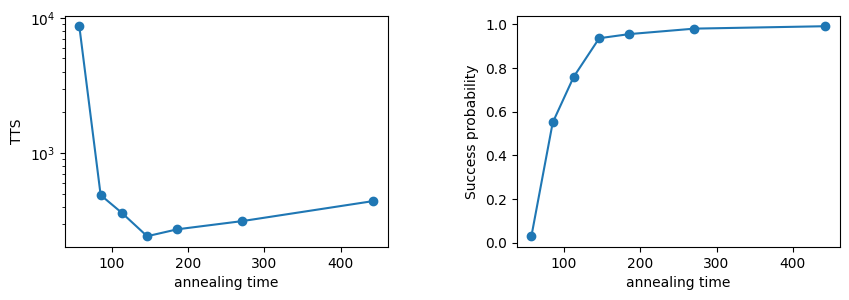

In [61]:
# 各種描画の設定を行います。
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,3))
plt.subplots_adjust(wspace=0.4)
fontsize = 10

# TTSを描画します。
axL.plot(tau_list, TTS_list, '-o')
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_yscale("log")
axL.set_ylabel('TTS', fontsize=fontsize)

# 成功確率psを描画します。
axR.plot(tau_list, ps_list, '-o')
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Success probability', fontsize=fontsize)

上の2つの図は両方とも、横軸が1回のアニーリングにかかる計算時間となっています。 
アニーリング時間が増加と共に、成功確率が上がっていくことがわかります。
この図では、アニーリング時間が200程度でおおよそ成功確率が収束している振る舞いが見られます。

TTSを見ると、アニーリング時間が200程度は減少、つまり、素早く最適解が得られるようになっていますが、それ以上ゆっくりアニールすると、TTSが緩やかに上昇していることがわかります。
これは、アニーリング時間に対する成功確率が頭打ちになっている傾向を示しています。
なので、必要な成功確率が補償できた時点でアニーリングをやめたいときの指標として、これらを有効に使っていきましょう。
TTSを縦軸に横軸にアニーリング時間を取った図において、最小のTTSが検証したインスタンスに対するアニーリングアルゴリズムの最良な計算時間となります。

この最小のTTSがアルゴリズムの計算時間としてよく用いられる指標になります。

アニーリングアルゴリズムは最適解への漸近的な収束性が存在するアルゴリズムなので、ほとんどの場合はアニーリング時間を長くすれば、残留エネルギーが小さくなっていきます。
残留エネルギーのアニーリング時間依存性をプロットすることで、アニーリングアルゴリズムがうまく動いていることを確認できます。
上記のOpenJijのテストでエネルギーの平均値を保存していたので、その結果をプロットしてみましょう。

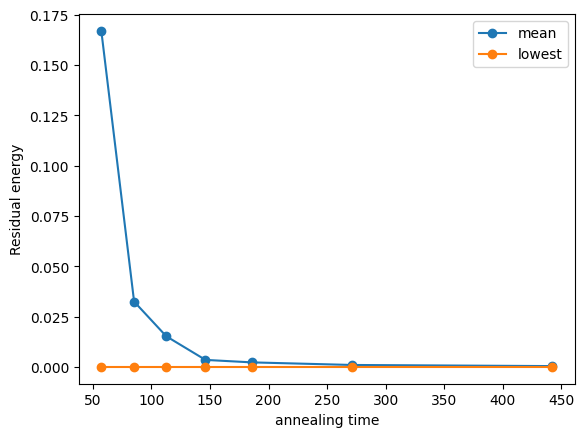

In [62]:
plt.plot(tau_list, (np.array(e_mean_list) - minimum_energy)/np.abs(minimum_energy), '-o', label='mean')
plt.plot(tau_list, (np.array(e_min_list) - minimum_energy)/np.abs(minimum_energy), '-o', label='lowest')
plt.xlabel('annealing time', fontsize=fontsize)
plt.ylabel('Residual energy', fontsize=fontsize)
plt.legend()
plt.show()

しっかりアニーリング時間が伸びるごとに平均残留エネルギーが下がっていることがわかります。先ほどは成功確率からTTSなどを計算しましたが、なかなか問題が難しく、最適解が得られない場合にちゃんとアニーリングがうまくいっているかを図る指標としても残留エネルギーは有効です。
また残留エネルギーは得られたエネルギー値を最適値でシフトしているだけなので、最適値を知らない場合でも、エネルギーのアニーリング時間依存性というプロットは有効です。
最適値がわからない場合でのアルゴリズムの比較などを行う際に使うことができます。

## OpenJijのベンチマーク機能を用いた評価指標の計算
ここまでは原理を確認するためにスクリプトを作成し、TTSや成功確率等を計算してきました。
ですが、OpenJijにはデフォルトでTTS, 残留エネルギー, 成功確率を評価してくれるベンチマーク関数`openjij.solver_benchmark`が存在します。  

### solver_benchmark関数

`solver_benchmark`関数はTTS, 残留エネルギー, 成功確率を計算し、その値や標準誤差を返します。
`solver_benchmark`関数の引数や返り値については、後ほど説明するので、
まずは、先ほどと同じ設定で実際にこのベンチマーク関数を用いてTTSなどを計算してみましょう。

In [63]:
# 最適解を定義します。
correct_state = [(-1)**i for i in range(N)]

# num_sweepsとnum_readsの反復数を与えます。
num_sweeps_list = [30, 50, 80, 100, 150, 200,300,500]
num_reads = 1000

# benchmark関数を用いてTTS, 残留エネルギー, 成功確率を計算します。
result = oj.solver_benchmark(
                      solver=lambda time, **args: oj.SASampler(num_sweeps=time, num_reads=num_reads).sample_ising(h,J), 
                      time_list=num_sweeps_list, solutions=[correct_state], p_r=0.99
            )

Text(0, 0.5, 'Success probability')

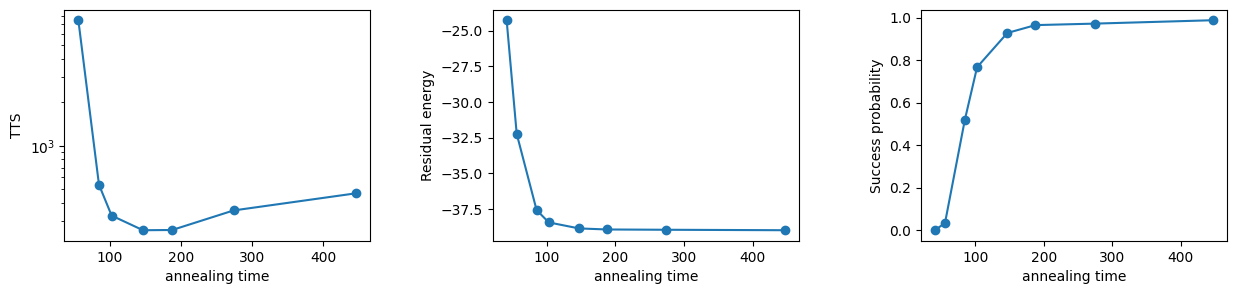

In [64]:
# 各種描画を行うための設定を行います。
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)
fontsize = 10

# TTSを描画します。
axL.plot(result['time'], result['tts'],'-o')
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_yscale("log")
axL.set_ylabel('TTS', fontsize=fontsize)

# 残留エネルギーを描画します。
axC.plot(result['time'], result['residual_energy'],'-o')
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Residual energy', fontsize=fontsize)

# 最適解が出現した確率を描画します。
axR.plot(result['time'], result['success_prob'],'-o')
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Success probability', fontsize=fontsize)

先ほど自分でスクリプトを書いた場合と同じ結果が再現できていることがわかります。
このようにして簡単にベンチマークをとることができます。  

さらに、`solver_benchmark`関数は標準誤差も計算してくれるので、エラーバー付きの結果も簡単にプロットすることができます。

Text(0, 0.5, 'Success probability')

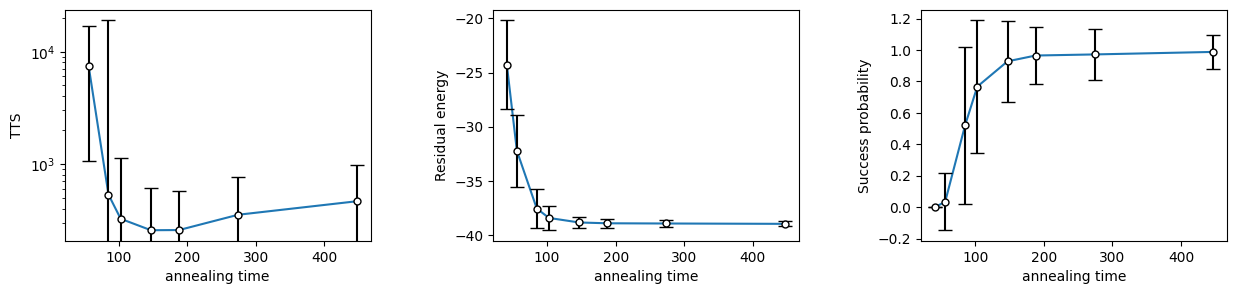

In [65]:
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)

fontsize = 10
axL.plot(result['time'], result['tts'])
axL.errorbar(result['time'], result['tts'], yerr = (result['se_lower_tts'],result['se_upper_tts']), capsize=5, fmt='o', markersize=5, ecolor='black', markeredgecolor = "black", color='w')
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_ylabel('TTS', fontsize=fontsize)
axL.set_yscale("log")

axC.plot(result['time'], result['residual_energy'])
axC.errorbar(result['time'], result['residual_energy'], yerr = result['se_residual_energy'], capsize=5, fmt='o', markersize=5, ecolor='black', markeredgecolor = "black", color='w')
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Residual energy', fontsize=fontsize)

axR.plot(result['time'], result['success_prob'])
axR.errorbar(result['time'], result['success_prob'], yerr = result['se_success_prob'], capsize=5, fmt='o', markersize=5, ecolor='black', markeredgecolor = "black", color='w')
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Success probability', fontsize=fontsize)

## ユーザ定義関数のベンチマーク

`solver`に入れる関数は`Response`クラスを返して、`.info['execution_time']`に計算時間を格納しておけばどのような自作関数を代入しても構いません。  

次に、適当なユーザsolver関数を作成してベンチマークを取る例として、
[1, 1, 1, 1,...]と[1, -1, 1, -1,...]と[-1, 1, -1, 1,...]の3つのスピン状態からランダムに一つの状態を返す関数を作成し、アニーリングアルゴリズムのベンチマークを取ってみましょう。最適解は[1, -1, 1, -1,...]とします。

In [44]:
import time 

def anti_ferro_solver(time_param, num_reads, h, J):
#     """
#     [1, 1, 1,...]と[1,-1,1,...]と[-1,1,-1,...]の3つの状態からランダムに選ぶ関数です。
#     """
    
    # 入力された h と J から添字の集合を作成します。
    indices = set(h.keys())
    indices = list(indices | set([key for keys in J.keys() for key in keys]))
    
    # [1, 1, 1,...]の状態を作成します。
    ones_state = list(np.ones(len(indices), dtype=int))
    
    # [-1, 1, -1,...]の状態を作成します。
    minus_plus_state = np.ones(len(indices), dtype=int)
    minus_plus_state[::2] *= -1
    # [1, -1, 1,...]の状態を作成します。
    plus_minus_state = -1 * minus_plus_state
    
    # 実行時間を計測を開始します。
    start = time.time()
    _states = [ones_state, list(minus_plus_state), list(plus_minus_state)]
    
    # 3つの状態からランダムに1つの状態を選出します。
    state_record = [_states[np.random.randint(3)] for _ in range(num_reads)]
    # state_recordをndarrayに変換します。
    state_record = np.array(state_record)
    
    # ここでは適当に計算時間をかさ増しします。
    exec_time = (time.time()-start) * 10**3 * time_param
    # ここでは適当にエネルギーを計算します。
    energies = [sum(state) for state in state_record]
    
    # 状態のリストと添字を紐づけるために、1つのタプルにします。
    samples_like = (state_record, indices)
        
    # dimodのfrom_samplesを参考に、Responseクラスに状態とエネルギーを格納します。
    response = oj.Response.from_samples(samples_like=samples_like, energy=energies, vartype='SPIN')
    # response.infoの'execution_time'キーに計算時間を代入します。
    response.info['execution_time'] = exec_time
    
    return response

OpenJijのresponseはdimodのSampleSetを参考にして作られています。
そのため、OpenJijに慣れておけばdimodの利用やD-Wave実行への移行も容易になるというメリットがあります。
dimodのSampleSetの詳細については以下のdimodのSamplesページをご覧ください。  
[Samples](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/sampleset.html)

自作solver関数ができたので、この関数に対してベンチマークをとってみましょう。
ここでは、ランダムに状態を返すので、最適値はありませんがTTSの計算のために、`[1, -1, 1,...]`を最適解としておきます。

In [58]:
# 最適解を[1, -1, 1,...]と定義しておきます。
correct_state = [(-1)**i for i in range(N)]

# num_sweepsとnum_readsを定義しておきます。
num_sweeps_list = list(range(10, 101, 10))
num_reads = 2000

# benchmark関数でTTS, 残留エネルギー, 成功確率を計算します。
result = oj.solver_benchmark(
                      solver= lambda time_param, **args: anti_ferro_solver(time_param, num_reads, h, J), 
                      time_list=num_sweeps_list, solutions=[correct_state], p_r=0.99
              )

Text(0, 0.5, 'Success probability')

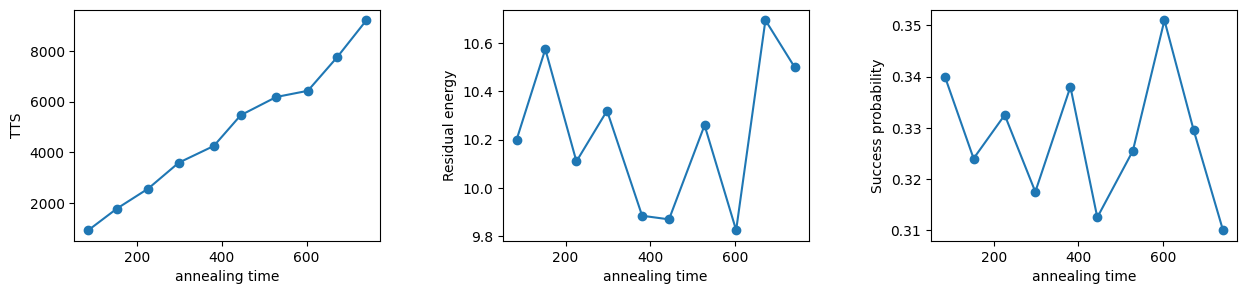

In [59]:
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)

fontsize = 10
axL.plot(result['time'], result['tts'],'o-')
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_ylabel('TTS', fontsize=fontsize)

axC.plot(result['time'], result['residual_energy'],'o-')
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Residual energy', fontsize=fontsize)

axR.plot(result['time'], result['success_prob'],'o-')
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Success probability', fontsize=fontsize)

3つの状態からランダムにひとつ1つ最適解の状態を選んでいるので、成功確率はおよそ$1/3\approx 0.33\cdots$くらいになるはずです。  
上の成功確率の図も縦軸がその程度の数値になっています。

このようにうまくsolver関数を作っておけば、OpenJijのソルバーに限らず自作のソルバーに対して、TTS, 残留エネルギー, 成功確率を計算することが可能です。 

### `solver_benchmark`関数の詳細
ここでは、`solver_benchmark`関数の引数および、その返り値について説明します。
#### `solver_benchmark`関数の引数

- solver: function  
    `Response`クラスを返す関数です。`time`と`num_reads`という引数を持つ必要があります。
    `time`は計算時間を制御するパラメータです。`SASampler`の場合は`num_sweeps`に相当します。
    `num_reads`はTTSや残留エネルギーなどを計算するときに必要なサンプリング回数を指定します。
    また関数の戻り値の`Response.info`には、`time_name`という引数で指定する文字列をキーワードで持ち、`time_name`に紐づく値は1回あたりの計算時間が格納されている必要があります。
- time_list: list  
    solverの`time`引数に入れる値のリストです。
- solutions: list(list: state)  
    基底状態(最適解)となる状態のリストです。縮退(同じ状態が複数あり見分けがつかない状態)している場合は[state1, state2]のように、複数の状態を入れます。
- args: dict
    solverにオプションで必要な場合につけます。デフォルトでは`args = {}`です。
- p_r: 0 < float <= 1  
    TTSを計算するために必要な値です。上述のTTSの説明のp_Rに相当します。
- ref_energy: float  
    参照エネルギーです。次のmeasure_with_energyと合わせて用います。デフォルトでは`ref_energy = 0`です。
- measure_with_energy: bool  
    False: スピンの状態が基底状態と一致しているとき、成功とカウントします。  
    True: エネルギーが先ほどのref_energy以下のとき、成功とカウントします。基底状態がわからない場合に用います。  
    デフォルトではFalseです。
- time_name: str  
    `Response.info`に入っている実行時間と紐づくキーを指定します。デフォルトでは`'execution_time'`です。

#### `solver_benchmark`関数の返り値
返り値はbenchmark計算の結果が以下のように辞書型で格納されています。

- time: 実行時間のリスト
- success_prob: 成功確率のリスト
- tts: TTSのリスト
- residual_energy: 残留エネルギーのリストで
- info: (dict) ベンチマーク関数のパラメータ情報
- se_success_prob: 成功確率の標準誤差のリスト  
      iteration 回アニーリング時、成功確率の期待値の標準偏差  
      step_num ごとに、格納されている

- se_residual_energy: 残留エネルギーの標準誤差のリスト  
      iteration 回アニーリング時の、残留エネルギー値の平均の標準偏差  
      step_num ごとに、格納されている

- se_lower_tts: TTSの下位誤差のリスト
      成功確率の上位誤差を基に算出したTTSの下位誤差

- se_upper_tts: TTSの上位誤差のリスト
      成功確率の下位誤差を基に算出したTTSの下位誤差
